In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

df = pd.read_csv(r'/kaggle/input/dataset/behaviors.tsv', sep='\t', header=None, names=['Impression_ID', 'User_ID', 'Time', 'History', 'Impressions'])
df.head()
df2 = pd.read_csv(r'/kaggle/input/dataset/news.tsv', sep='\t', header=None, names=['News_ID', 'Category', 'Subcategory', 'Title', 'Abstract', 'URL', 'Title_Entities', 'Abstract_Entities'])
df2.head()

from tqdm import tqdm
interactions = []

for _, row in tqdm(df.iterrows()):
    user_id = row['User_ID']
    impressions = row['Impressions'].split()
    for impression in impressions:
        news_id, clicked = impression.split('-')
        interactions.append((user_id, news_id, int(clicked)))  # clicked: 1 if clicked, else 0

interaction_df = pd.DataFrame(interactions, columns=['User_ID', 'News_ID', 'Clicked'])

import pandas as pd
from scipy.sparse import csr_matrix

interaction_df = pd.read_csv(r"/kaggle/input/dataset/interaction_df.csv")
interaction_df_aggregated = interaction_df.groupby(['User_ID', 'News_ID'], as_index=False).agg({'Clicked': 'sum'})

user_mapping = {user: idx for idx, user in enumerate(interaction_df_aggregated['User_ID'].unique())}
item_mapping = {item: idx for idx, item in enumerate(interaction_df_aggregated['News_ID'].unique())}

interaction_df_aggregated['User_Code'] = interaction_df_aggregated['User_ID'].map(user_mapping)
interaction_df_aggregated['Item_Code'] = interaction_df_aggregated['News_ID'].map(item_mapping)

interaction_df_aggregated,test_df = train_test_split(interaction_df_aggregated,test_size=0.2,random_state=42)

user_ids = interaction_df_aggregated['User_Code']
news_ids = interaction_df_aggregated['Item_Code']
clicked_values = interaction_df_aggregated['Clicked']

interaction_df_aggregated['Clicked'] = np.where(interaction_df_aggregated['Clicked'] > 0, 1, 0)
user_item_sparse_matrix = csr_matrix((clicked_values, (user_ids, news_ids)),
                                     shape=(len(user_mapping), len(item_mapping)))

print("Sparse Matrix Shape:", user_item_sparse_matrix.shape)

import pickle
with open('user_mapping.pkl', 'wb') as f:
    pickle.dump(user_mapping, f)

with open('item_mapping.pkl', 'wb') as f:
    pickle.dump(item_mapping, f)
    
import numpy as np
from scipy.sparse.linalg import svds

user_item_sparse_matrix = user_item_sparse_matrix.astype(float)


k = 300  # Number of latent features

# Compute SVD (U, S, Vt) where:
# U - User latent matrix
# S - Singular values (diagonal matrix)
# Vt - Transpose of the item latent matrix
U, S, Vt = svds(user_item_sparse_matrix, k=k)

S = np.diag(S)


user_latent_vectors = U @ S 
item_latent_vectors = Vt.T @ S 

print(f"User Latent Vectors Shape: {user_latent_vectors.shape}")
print(f"Item Latent Vectors Shape: {item_latent_vectors.shape}")

np.save('user_latent_vectors.npy', user_latent_vectors)
np.save('item_latent_vectors.npy', item_latent_vectors)

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

df2['Abstract'] = df2['Abstract'].fillna("")

tfidf_vectorizer = TfidfVectorizer(max_features=300)  
tfidf_matrix = tfidf_vectorizer.fit_transform(df2['Abstract'])

tfidf_matrix_dense = tfidf_matrix.toarray()

tfidf_df = pd.DataFrame(tfidf_matrix_dense, index=df2['News_ID'])

tfidf_df = tfidf_df.loc[item_mapping.keys()]
tfidf_df.index = [item_mapping[news_id] for news_id in tfidf_df.index]  

b = interaction_df_aggregated['Clicked'].mean()
user_avg_clicked = interaction_df.groupby('User_ID')['Clicked'].mean()
item_avg_clicked = interaction_df.groupby('News_ID')['Clicked'].mean()
interaction_df['User_Deviation'] = interaction_df['User_ID'].map(user_avg_clicked) - interaction_df['Clicked']
interaction_df['Item_Deviation'] = interaction_df['News_ID'].map(item_avg_clicked) - interaction_df['Clicked']

print(interaction_df[['User_ID', 'News_ID', 'Clicked', 'User_Deviation', 'Item_Deviation']].head())

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

print('tf shape before: ',tfidf_df.shape)
tfidf_df = pd.DataFrame(normalize(tfidf_df,axis=1,norm='l2'))
print("tf shape: ",tfidf_df.shape)

similarity_matrix = cosine_similarity(tfidf_df)
weighted_sums = []

top_k = 5

for i in range(len(tfidf_df)):
   
    similarity_scores = similarity_matrix[i]
    similarity_scores[i] = -1
    top_5_indices = similarity_scores.argsort()[-top_k:][::-1] 
    top_5_similarities = similarity_scores[top_5_indices]
    norm_factor = np.sum(top_5_similarities)
    normalized_weights = top_5_similarities / norm_factor if norm_factor != 0 else top_5_similarities
    weighted_sum_vector = np.zeros_like(tfidf_df.iloc[0].values)

    for j, idx in enumerate(top_5_indices):
        weight = normalized_weights[j]
        weighted_sum_vector += weight * tfidf_df.iloc[idx].values
    
    weighted_sums.append(weighted_sum_vector)

weighted_sum_df = pd.DataFrame(weighted_sums, index=tfidf_df.index)
print(weighted_sum_df)

weighted_sum_df.shape        

156965it [00:14, 10849.12it/s]


Sparse Matrix Shape: (50000, 20288)
User Latent Vectors Shape: (50000, 300)
Item Latent Vectors Shape: (20288, 300)
  User_ID News_ID  Clicked  User_Deviation  Item_Deviation
0  U13740  N55689        1       -0.990506       -0.764346
1  U13740  N35729        0        0.009494        0.217019
2  U91836  N20678        0        0.051282        0.081881
3  U91836  N39317        0        0.051282        0.081494
4  U91836  N58114        0        0.051282        0.021003
tf shape before:  (20288, 300)
tf shape:  (20288, 300)
       0        1         2         3    4         5    6    7    8    \
0      0.0  0.00000  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.0   
1      0.0  0.00000  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.0   
2      0.0  0.00000  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.0   
3      0.0  0.00000  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.0   
4      0.0  0.00000  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.0   
...    ...      ...       ...       .

(20288, 300)

In [129]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self,user_vecs, item_vecs, weighted_df, num,device):
        super().__init__()
        self.user_latent_vecs = nn.Parameter(torch.tensor(user_vecs, dtype=torch.float32).to(device))
        self.item_latent_vecs = nn.Parameter(torch.tensor(item_vecs, dtype=torch.float32).to(device))
        self.weighted_sum_df = torch.tensor(weighted_df.values, dtype=torch.float32).to(device)
        self.neighbours = num
        
    def forward(self, input):
        users = input[:,0].long()
        items = input[:,1].long()
        user_vec = self.user_latent_vecs[users]
        item_vec = self.item_latent_vecs[items]
        neighbourhood_sum = self.weighted_sum_df[items]
        # print("user vec shape: ",user_vec.shape)
        # print("item vec shape: ",item_vec.shape)
        # print("neighbourhood_sum.shape: ",neighbourhood_sum.shape)
        output = torch.matmul(user_vec,(item_vec+neighbourhood_sum/self.neighbours).T)
        output = torch.sigmoid(output.diagonal(dim1=1, dim2=0))
        return output

In [141]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe.iloc[:,-3:]
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return torch.tensor(row.values, dtype=torch.float32)


df_0 = interaction_df_aggregated[interaction_df_aggregated['Clicked'] == 0]
df_1 = interaction_df_aggregated[interaction_df_aggregated['Clicked'] == 1]

df_0_downsampled = df_0.sample(len(df_1), random_state=42)

balanced_df = pd.concat([df_0_downsampled, df_1])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df['Clicked'].value_counts())
train_df, _ = train_test_split(balanced_df,test_size=0.3, random_state=42)
batch_size = 32
dataset = DataFrameDataset(train_df)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(user_latent_vectors,item_latent_vectors,weighted_sum_df,5,device)
model = model.to(device)
num_epochs = 100
opt = torch.optim.Adam(model.parameters(),lr = 1e-3)

Clicked
0    187484
1    187484
Name: count, dtype: int64


In [ ]:
def accuracy(probs,targs):
    preds = (probs>=0.5).float()
    return (torch.sum(preds==targs).item()/preds.shape[0])*100   

accs = []   
losses = []
for i in tqdm(range(num_epochs)):
    acc = 0
    losss = 0
    count = 0
    for it, j in enumerate(dataloader):
        count+=1
        j = j.to(device)
        targets = j[:,0]
        inputs = j[:,1:]
        output = model(inputs)
        loss = torch.nn.functional.binary_cross_entropy(output,targets)
        opt.zero_grad()
        losss+=loss.item()
        loss.backward()
        opt.step()
        ac = accuracy(output,targets)
        acc+=ac
    if((i+1)%10==0):
        torch.save(model.state_dict(), f"model_{i}.pt")
    if count!=0:
        accs.append(acc/count)
    losses.append(losss)
    print(f"epoch: {i}, loss: {losss}, acc: {accs[-1]}")

In [ ]:
num_iterations = len(dataloader)
print(f"Total number of iterations in dataloader: {num_iterations}")


In [ ]:
test_df.to_csv("test_df.csv")

In [142]:
import numpy as np
import pandas as pd
import torch

model = Model(user_latent_vectors,item_latent_vectors,weighted_sum_df,5,"cpu")

state_dict = torch.load("/kaggle/input/model-bs/model_99.pt",map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()
test_df = pd.read_csv("/kaggle/input/model-bs/test_df (1).csv")

/tmp/ipykernel_30/2759930301.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/model-bs/model_99.pt",map_location=torch.device('cpu'

In [143]:
test_df['Clicked'].value_counts()
test_df['Clicked'] = np.where(test_df['Clicked'] > 0, 1, 0)

In [144]:
test_df.shape

(997717, 6)

In [145]:
balanced_df = test_df
balanced_df = balanced_df.sample(frac=0.02, random_state=99).reset_index(drop=True)

In [146]:
balanced_df['Clicked'].value_counts()

Clicked
0    19012
1      942
Name: count, dtype: int64

In [147]:
bds = DataFrameDataset(balanced_df)
bds[0]

tensor([   0., 5058.,  517.])

In [148]:
targs = bds[:,0]
inps = bds[:,1:]
def accuracy(probs,targs):
    preds = (probs>=0.5).float()
    return (torch.sum(preds==targs).item()/preds.shape[0])*100   
ops = model(inps)

acc = accuracy(ops,targs)


In [149]:
print(f"Accuracy: {acc:.2f}")

Accuracy: 64.40


In [150]:
preds = (ops>=0.5).float()
targs

print("preds: ",preds[:10])
print("targs: ",targs[:10])

preds:  tensor([1., 0., 0., 1., 0., 0., 1., 0., 0., 1.])
targs:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


In [151]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

preds_np = preds.numpy() if isinstance(preds, torch.Tensor) else preds
targs_np = targs.numpy() if isinstance(targs, torch.Tensor) else targs
f1 = f1_score(targs_np, preds_np, average='weighted')
precision = precision_score(targs_np, preds_np, average='weighted')
recall = recall_score(targs_np, preds_np, average='weighted')
conf_matrix = confusion_matrix(targs_np, preds_np)

print(f"Accuracy: {acc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 64.40
F1 Score: 0.75
Precision: 0.92
Recall: 0.64
Confusion Matrix:
[[12388  6624]
 [  480   462]]


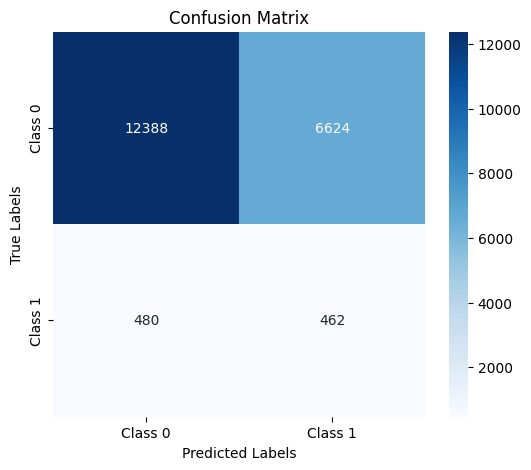

In [81]:
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [174]:
from sklearn.metrics import balanced_accuracy_score

# Calculate balanced accuracy directly
balanced_accuracy = balanced_accuracy_score(targs_np, preds_np)

0.5716268482571965
